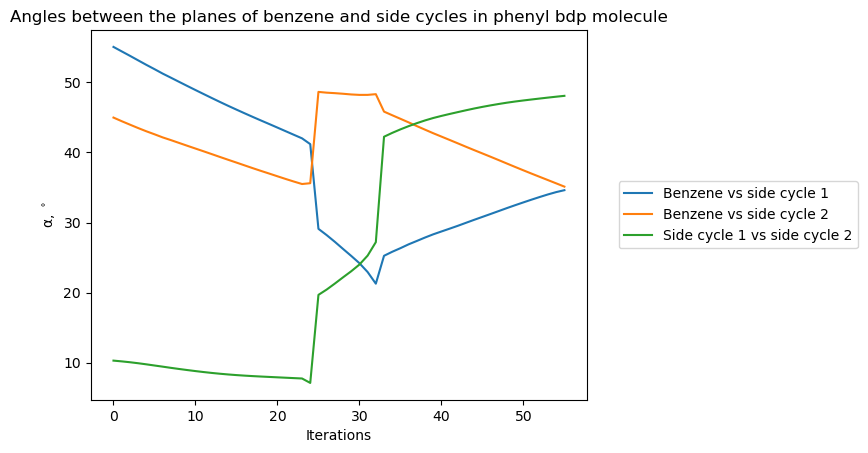

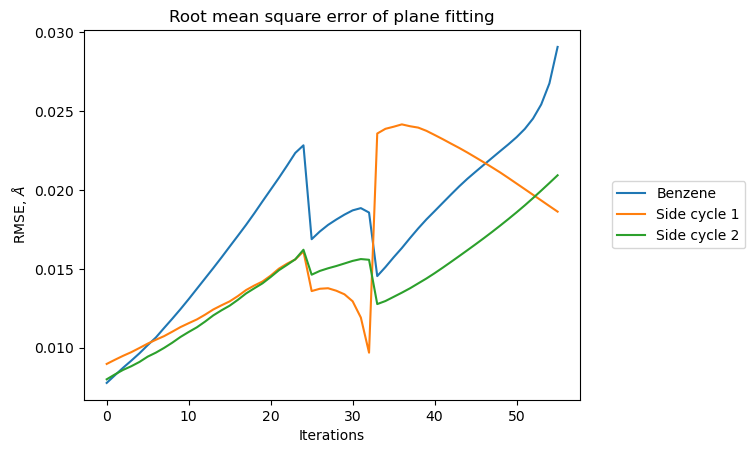

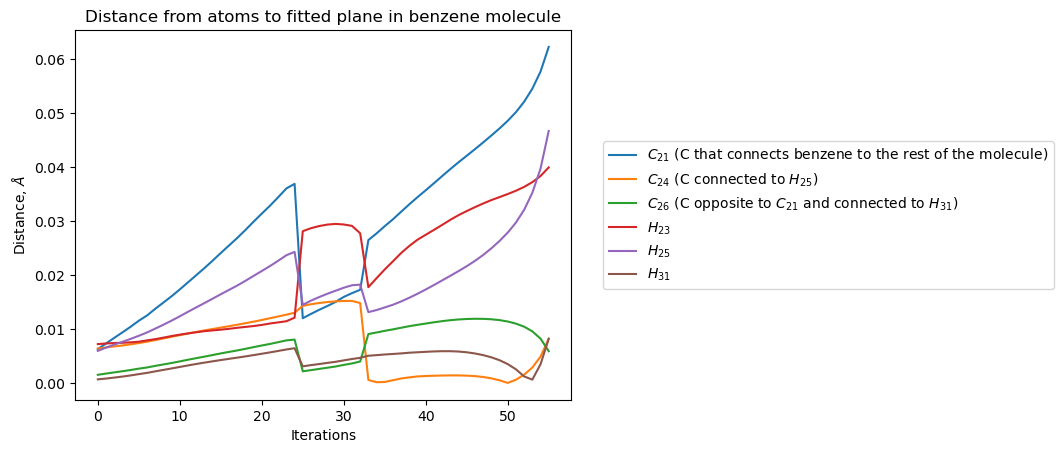

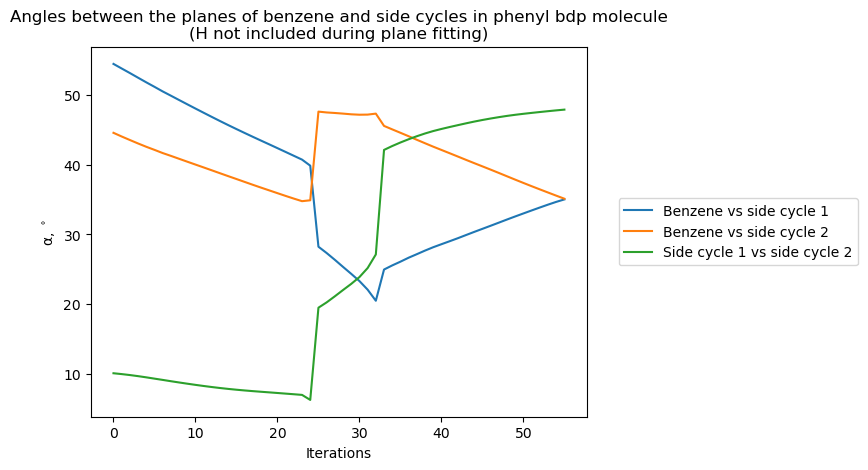

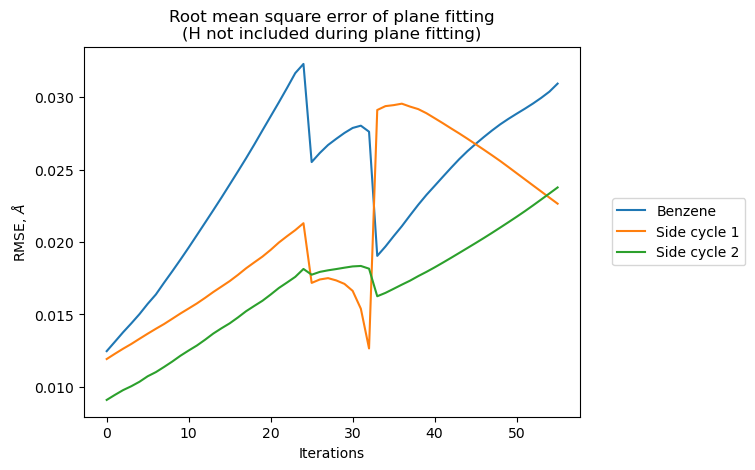

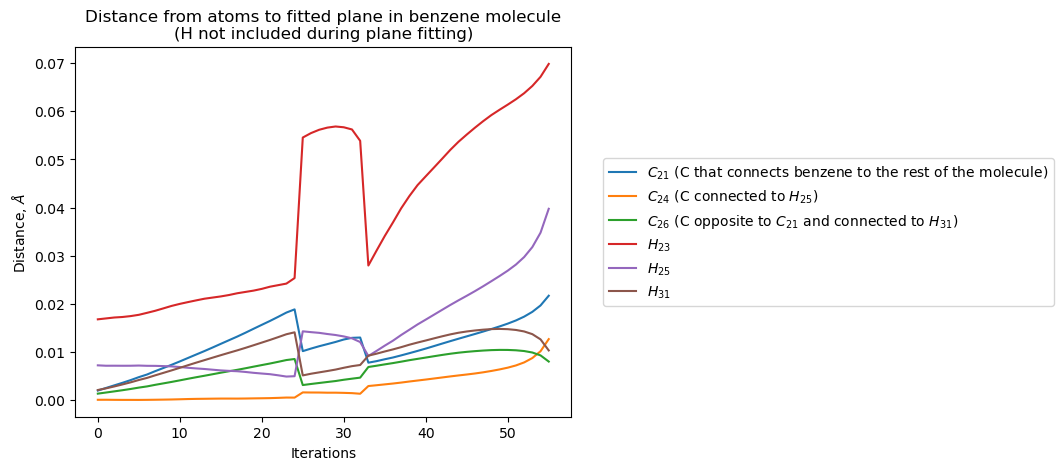

In [40]:
import numpy as np
import re
import math

# r, a, d in different contexts correspond to parameters related to distance (radius), angle and dihedral angle between atoms

def dc_from_gaussian_log(file_name, op="Optimized Parameters", m="Multiplicity",
                         gap=" ---------------------------------------------------------------------\n", 
                         mri="ModRedundant input"):
    """
    Reads and returns optimized Decartian coordinates (e-06 precision) from a Gaussian .log file.
    """
    
    toggle1, toggle2, toggle3, n_iterations, coords, labels = 0, 0, 0, 0, [], []
    with open(file_name, 'r') as f:
        for line in reversed(list(f)):
            if op in line:
                toggle1 = not toggle1
                n_iterations += 1
            elif toggle1:
                if toggle2:
                    if gap == line: toggle1 = not toggle1
                    else:
                        coords += [line.split()[3], line.split()[4], line.split()[5]]
                if gap == line: toggle2 = not toggle2
            elif mri in line: toggle3 = not toggle3
            elif toggle3:
                if m in line: toggle3 = not toggle3
                elif line.split(): labels += [line.split()[0]]
    coordinate_array = np.empty((n_iterations, len(labels), 3))
    coordinate_array.flat[:] = coords
    
    return np.transpose(coordinate_array, [1, 0, 2])[::-1, ::-1, :], np.array(labels[::-1])
            
def twod_linear_regression (point_coords):
    """
    Fits a plane through 3D points and returns the parameters a, b and c (z = ax + by + c).
    """
    
    x, y, z = point_coords.T[0], point_coords.T[1], point_coords.T[2]
    xm, ym, zm = np.mean(x), np.mean(y), np.mean(z)
    xs, ys, zs = x - xm, y - ym, z - zm
    xy = np.sum(x * ys) / np.sum(y * ys)
    a = np.sum((x - y * xy) * zs) / np.sum((x - y * xy) * xs)
    b = np.sum(y * (zs - a * xs)) / np.sum(y * ys)
    c = zm - a * xm - b * ym
    
    return (a, b, c)
    
def angle_between_planes (plane1, plane2):
    """
    Takes plane parameters as input and returns the angle between the planes
    (given the parametrization z = ax + by + c the normal vector to this plane is n = [a, b, -1]).
    """
    
    n1 = np.array([plane1[0], plane1[1], -1]) / (plane1[0] ** 2 + plane1[1] ** 2 + 1) ** 0.5
    n2 = np.array([plane2[0], plane2[1], -1]) / (plane2[0] ** 2 + plane2[1] ** 2 + 1) ** 0.5
    angle = math.acos(np.sum(n1*n2)) * 180 / math.pi
    if angle > 90: angle = 180 - angle
        
    return angle

def distance_from_point_to_plane (point, plane):
    """
    Takes point coordinates and plane parameters as input and returns the shortest distance from the point to the plane.
    """
    
    return abs(plane[0] * point[0] + plane[1] * point[1] - 1 * point[2] + plane[2]) / (plane[0] ** 2 + plane[1] ** 2 + 1) ** 0.5

def dists_to_plane_and_rmse (points, plane):
    """
    Takes point coordinates and plane parameters as input
    and returns the shortest distances from the points to the plane + root mean square error (RMSE).
    """
    
    distances = np.array([distance_from_point_to_plane(point, plane) for point in points])
    mean_square_error = np.sum(np.square(distances)) / len(distances)
    
    return distances, mean_square_error ** 0.5


def ic_from_gaussian_log (file_name, r="! R", a="! A", d="! D", op="Optimized Parameters", m="Multiplicity"):
    """
    Reads and returns optimized internal coordinates (e-04 precision) from a Gaussian .log file.
    Additionally, this function constructs a dictionary to make coordinate labels more readable.
    """
    
    n_iterations, n_atoms, toggle, coords, labels = 0, 0, 0, [], []
    label_swap_dict = {"(": "(", ")": ")", ",": ",", "R": "r", "A": "θ", "D": "φ"}
    with open(file_name, 'r') as f:
        for line in f:
            if toggle:
                if not line.split(): toggle = not toggle
                else:
                    n_atoms += 1
                    label_swap_dict[str(n_atoms)] = "$" + str(line.split()[0]) + "_{" + str(n_atoms) + "}$"
            elif m in line: toggle = not toggle
            elif op in line: n_iterations += 1
            elif r in line or a in line or d in line:
                coords += [line.split()[3]]
                if n_iterations < 1:
                    labels += [line.split()[2]]
    coordinate_array = np.empty((n_iterations, len(labels)))
    coordinate_array.flat[:] = coords[len(labels):]
    
    return coordinate_array.T, np.array(labels), label_swap_dict

def angle_jump_fix (coordinates, threshold=150):
    """
    Fixes angle jumping issue due to them being defined on [-180, 180] interval.
    """
    
    for i in range(coordinates.shape[0]): 
        if np.amin(coordinates[i, :]) < -threshold and np.amax(coordinates[i, :]) > threshold:
            for j in range(len(coordinates[i])):
                if coordinates[i, j] < 0:
                    coordinates[i, j] += 360
                    
    return coordinates

def c_stats (coords):
    """
    Computes covariance matrix and standard deviations for all coordinates.
    """
    
    covariance_matrix = np.cov(coords)
    standard_deviations = np.sqrt(np.diag(covariance_matrix))
    
    return covariance_matrix, standard_deviations
    
def par_that_vary_most (std_devs, index_shift=0, threshold=0.5):
    """
    Returns indices of parameters that vary most. One kind of parameters please!
    """
    
    indices = []
    for i, element in enumerate(std_devs / np.amax(std_devs)):
        if element >= threshold:
            indices += [(i+index_shift)]
            
    return indices

def better_labels (labels, label_swap_dictionary):
    """
    Makes Gaussian internal coordinate labels more readable.
    """
    
    return ["".join([label_swap_dictionary[l] for l in re.findall("[0-9]+|[^0-9]", label)]) for label in labels]

def coord_type_count (labels):
    """
    Counts the amount of distance, angle and dihedral angle coordinates.
    """
    
    r, a = 0, 0
    for label in labels:
        if "r" in label: r += 1
        elif "θ" in label: a += 1
        else: break
            
    return r, a, len(labels) - r - a 

def rescale_covariance_matrix (cov_mat, rt, rat):
    """
    Rescales submatrices of covariance matrix, that correspond to different mixes of internal coordinates, individually.
    """
    
    cov_mat[:rt, :rt] = cov_mat[:rt, :rt] / np.amax(cov_mat[:rt, :rt])
    cov_mat[rt:rat, :rt] = cov_mat[rt:rat, :rt] / np.amax(cov_mat[rt:rat, :rt])
    cov_mat[:rt, rt:rat] = cov_mat[rt:rat, :rt].T
    cov_mat[rat:, :rt] = cov_mat[rat:, :rt] / np.amax(cov_mat[rat:, :rt])
    cov_mat[:rt, rat:] = cov_mat[rat:, :rt].T
    cov_mat[rt:rat, rt:rat] = cov_mat[rt:rat, rt:rat] / np.amax(cov_mat[rt:rat, rt:rat])
    cov_mat[rat:, rt:rat] = cov_mat[rat:, rt:rat] / np.amax(cov_mat[rat:, rt:rat])
    cov_mat[rt:rat, rat:] = cov_mat[rat:, rt:rat].T
    cov_mat[rat:, rat:] = cov_mat[rat:, rat:] / np.amax(cov_mat[rat:, rat:])
    
    return cov_mat

def group_coords_by_cov (cov_mat, labels, threshold=0.9):
    """
    Sorts coordinate indices into bins judging by whether they describe the same atoms and whether they covariate enough.
    """
    
    bins, empty = [], 0
    atom_lists = atom_lists_from_labels(labels)
    for i in range(2, len(atom_lists)):
        for j in range(1, i):
            if threshold <= abs(cov_mat[i, j]):
                if not set(atom_lists[i]).isdisjoint(atom_lists[j]):
                    for b in range(len(bins)):
                        if i in bins[b] and j not in bins[b]: bins[b] += [j]
                        elif j in bins[b] and i not in bins[b]: bins[b] += [i]
                        elif i not in bins[b] and j not in bins[b]: empty += 1
                    if empty == len(bins): bins += [[i, j]]
                    empty = 0
                    
    return bins

def atom_lists_from_labels (labels):
    """
    Returns lists of numbers that specify which atoms are linked by specific internal coordinates.
    """
    
    return [re.findall(r'\d+', label) for label in labels]
    
def main(plot=1, internal=0, decartian=1):
    """
    Showcase of my progress.
    """
    
    if internal:
        coordinates, labels, label_swap_dictionary = ic_from_gaussian_log("bdp-phenyl-meoh-S1-fscan-fa.log")
        coordinates = angle_jump_fix(coordinates)
        labels = better_labels(labels, label_swap_dictionary)
        r_total, a_total, d_total = coord_type_count(labels)
        ra_total = r_total + a_total
        cov_mat, std_devs = c_stats(coordinates)
        cov_mat = rescale_covariance_matrix(cov_mat, r_total, ra_total)
        atom_bins = group_coords_by_cov(cov_mat, labels)

        if plot:
            import matplotlib.pyplot as plt
            plt.rcParams["figure.figsize"] = (7, 7)

            plt.imshow((cov_mat), cmap='hot', interpolation='nearest')
            plt.colorbar()
            plt.suptitle("Rescaled coordinate covariance matrix heatmap")
            plt.xlabel('Coordinate number')
            plt.ylabel('Coordinate number')
            plt.show()

            for abin in atom_bins:
                for c in abin:
                    plt.plot(coordinates[c] / np.amax(np.absolute(coordinates[c])), label=labels[c])
                plt.suptitle("Various normalized to unity coordinates grouped due to covariating enough and describing the same atoms")
                plt.xlabel('Iterations')
                plt.ylabel('Dimensionless values of internal coordinates')
                plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
                plt.show()

            """     

            #plt.plot(labels[:r_total], std_devs[:r_total])
            plt.plot(std_devs[:r_total])
            plt.suptitle("Standard deviations of bond lengths")
            plt.xlabel('Bond number')
            plt.ylabel('σ(r), r’$\AA$’')
            #plt.xticks(fontsize=8, rotation=90)   
            plt.show()

            #plt.plot(labels[r_total:r_total+a_total], std_devs[r_total:r_total+a_total])
            plt.plot(std_devs[r_total:ra_total])
            plt.suptitle("Standard deviations of bond angles")
            plt.xlabel('Bond angle number')
            plt.ylabel('σ(θ), $^\circ$')
            #plt.xticks(fontsize=8, rotation=90)
            plt.show()

            #plt.plot(labels[r_total+a_total:], std_devs[r_total+a_total:])
            plt.plot(std_devs[ra_total:])
            plt.suptitle("Standard deviations of dihedral angles")
            plt.xlabel('Dihedral angle number')
            plt.ylabel('σ(φ), $^\circ$')
            #plt.xticks(fontsize=8, rotation=90)
            plt.show()

            for p in par_that_vary_most(std_devs[:r_total]):
                plt.plot(coordinates[p], label=labels[p])
            plt.title("The dependence of bond lengths that change most on iterations")
            plt.xlabel("Iterations")
            plt.ylabel('r, $\AA$')
            plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
            plt.show()

            for i in par_that_vary_most(std_devs[r_total:ra_total], r_total):
                plt.plot(coordinates[i], label=labels[i])
            plt.title("The dependence of bond angles that change most on iterations")
            plt.xlabel("Iterations")
            plt.ylabel('θ, $^\circ$')
            plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
            plt.show()

            for i in par_that_vary_most(std_devs[ra_total:], ra_total):
                plt.plot(coordinates[i], label=labels[i])
            plt.title("The dependence of dihedral angles that change most on iterations")
            plt.xlabel("Iterations")
            plt.ylabel('φ, $^\circ$')
            plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
            plt.show()

            """
            
    if decartian:
        coords, labels = dc_from_gaussian_log("bdp-phenyl-meoh-S1-fscan-fa.log")
        
        """
        
        # Plots the planes fitted through the cyclic carbon chains and hydrogens
        i = 5
        group1, group2, group3 = coords[20:, i, :], coords[1:9, i, :], coords[10:18, i, :]
        plane1, plane2, plane3 = twod_linear_regression(group1), twod_linear_regression(group2), twod_linear_regression(group3)
        a1, a2, a3 = angle_between_planes(plane1, plane2), angle_between_planes(plane1, plane3), angle_between_planes(plane2, plane3)
        print("Angles (in degrees) between benzene plane and the planes of the 2 side cycles in Bodipy molecule:\n", a1, a2,
             "\nAngle (in degrees) between the 2 side cycles in Bodipy molecule:\n", a3)

            if plot:
                import matplotlib.pyplot as plt
                fig = plt.figure()
                ax = fig.add_subplot(projection='3d')

                x, y = np.meshgrid(np.linspace(-7, 7, 5), np.linspace(-7, 7, 5))
                z1, z2, z3 = plane1[0] * x + plane1[1] * y + plane1[2], plane2[0] * x + plane2[1] * y + plane2[2], plane3[0] * x + plane3[1] * y + plane3[2]

                ax.scatter(group1[:, 0], group1[:, 1], group1[:, 2], c="red")
                ax.plot_surface(x, y, z1, alpha=0.1, color="red")
                ax.scatter(group2[:, 0], group2[:, 1], group2[:, 2], c="blue")
                ax.plot_surface(x, y, z2, alpha=0.1, color="blue")
                ax.scatter(group3[:, 0], group3[:, 1], group3[:, 2], c="green")
                ax.plot_surface(x, y, z3, alpha=0.1, color="green")

                ax.set_xlim(-7, 7)
                ax.set_ylim(-7, 7)
                ax.set_zlim(-7, 7)
                plt.gca().view_init(10, 180)
                plt.show()
                
        """
        
        # Analysis fitting the plane through all atoms, i. e. hydrogen atoms included.
        
        angles, mses, dists1, dists2, dists3 = [], [], [], [], []
        for i in range(coords.shape[1]):
            group1, group2, group3 = coords[20:, i, :], coords[1:9, i, :], coords[10:18, i, :]
            plane1, plane2, plane3 = twod_linear_regression(group1), twod_linear_regression(group2), twod_linear_regression(group3)
            angles += [[angle_between_planes(plane1, plane2), angle_between_planes(plane1, plane3), angle_between_planes(plane2, plane3)]]
            dist1, mse1 = dists_to_plane_and_rmse(group1, plane1)
            dist2, mse2 = dists_to_plane_and_rmse(group2, plane2)
            dist3, mse3 = dists_to_plane_and_rmse(group3, plane3)
            dists1 += [dist1]
            dists2 += [dist2]
            dists3 += [dist3]
            mses += [[mse1, mse2, mse3]]
        angles, dists1, dists2, dists3, mses = np.array(angles), np.array(dists1), np.array(dists2), np.array(dists3), np.array(mses)
        
        if plot:
            import matplotlib.pyplot as plt
            
            plt.plot(angles.T[0], label="Benzene vs side cycle 1")
            plt.plot(angles.T[1], label="Benzene vs side cycle 2")
            plt.plot(angles.T[2], label="Side cycle 1 vs side cycle 2")
            plt.title("Angles between the planes of benzene and side cycles in phenyl bdp molecule")
            plt.xlabel("Iterations")
            plt.ylabel('α, $^\circ$')
            plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
            plt.show()
                
            plt.plot(mses.T[0], label="Benzene")
            plt.plot(mses.T[1], label="Side cycle 1")
            plt.plot(mses.T[2], label="Side cycle 2")
            plt.title("Root mean square error of plane fitting")
            plt.xlabel("Iterations")
            plt.ylabel('RMSE, $\AA$')
            plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
            plt.show()
            
            plt.plot(dists1.T[0, :], label="$C_{21}$ (C that connects benzene to the rest of the molecule)")
            plt.plot(dists1.T[3, :], label="$C_{24}$ (C connected to $H_{25}$)")
            plt.plot(dists1.T[5, :], label="$C_{26}$ (C opposite to $C_{21}$ and connected to $H_{31}$)")
            plt.plot(dists1.T[2, :], label="$H_{23}$")
            plt.plot(dists1.T[4, :], label="$H_{25}$")
            plt.plot(dists1.T[10, :], label="$H_{31}$")
            plt.title("Distance from atoms to fitted plane in benzene molecule")
            plt.xlabel("Iterations")
            plt.ylabel('Distance, $\AA$')
            plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
            plt.show()
            
        # Analysis fitting the plane through carbon and nitrogen atoms only, but including hydrogens for error estimation.
        
        angles, mses, dists1, dists2, dists3 = [], [], [], [], []
        for i in range(coords.shape[1]):
            group1 = np.array([coords[20, i, :], coords[21, i, :], coords[23, i, :], coords[25, i, :], coords[26, i, :], coords[28, i, :]])
            group2 = np.array([coords[1, i, :], coords[2, i, :], coords[4, i, :], coords[6, i, :], coords[8, i, :]])
            group3 = np.array([coords[10, i, :], coords[11, i, :], coords[13, i, :], coords[15, i, :], coords[17, i, :]])
            plane1, plane2, plane3 = twod_linear_regression(group1), twod_linear_regression(group2), twod_linear_regression(group3)
            group1, group2, group3 = coords[20:, i, :], coords[1:9, i, :], coords[10:18, i, :]
            angles += [[angle_between_planes(plane1, plane2), angle_between_planes(plane1, plane3), angle_between_planes(plane2, plane3)]]
            dist1, mse1 = dists_to_plane_and_rmse(group1, plane1)
            dist2, mse2 = dists_to_plane_and_rmse(group2, plane2)
            dist3, mse3 = dists_to_plane_and_rmse(group3, plane3)
            dists1 += [dist1]
            dists2 += [dist2]
            dists3 += [dist3]
            mses += [[mse1, mse2, mse3]]
        angles, dists1, dists2, dists3, mses = np.array(angles), np.array(dists1), np.array(dists2), np.array(dists3), np.array(mses)
        
        if plot:
            import matplotlib.pyplot as plt
            
            plt.plot(angles.T[0], label="Benzene vs side cycle 1")
            plt.plot(angles.T[1], label="Benzene vs side cycle 2")
            plt.plot(angles.T[2], label="Side cycle 1 vs side cycle 2")
            plt.title("Angles between the planes of benzene and side cycles in phenyl bdp molecule\n(H not included during plane fitting)")
            plt.xlabel("Iterations")
            plt.ylabel('α, $^\circ$')
            plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
            plt.show()
                
            plt.plot(mses.T[0], label="Benzene")
            plt.plot(mses.T[1], label="Side cycle 1")
            plt.plot(mses.T[2], label="Side cycle 2")
            plt.title("Root mean square error of plane fitting\n(H not included during plane fitting)")
            plt.xlabel("Iterations")
            plt.ylabel('RMSE, $\AA$')
            plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
            plt.show()
            
            plt.plot(dists1.T[0, :], label="$C_{21}$ (C that connects benzene to the rest of the molecule)")
            plt.plot(dists1.T[3, :], label="$C_{24}$ (C connected to $H_{25}$)")
            plt.plot(dists1.T[5, :], label="$C_{26}$ (C opposite to $C_{21}$ and connected to $H_{31}$)")
            plt.plot(dists1.T[2, :], label="$H_{23}$")
            plt.plot(dists1.T[4, :], label="$H_{25}$")
            plt.plot(dists1.T[10, :], label="$H_{31}$")
            plt.title("Distance from atoms to fitted plane in benzene molecule\n(H not included during plane fitting)")
            plt.xlabel("Iterations")
            plt.ylabel('Distance, $\AA$')
            plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
            plt.show()
    
def test():
    """
    For testing functions.
    """
    
    plane = twod_linear_regression(np.array([[0, 0, 5], [0, 1, 5], [1, 1, 5]]))
    print(str(plane), "\nExpected (0, 0, 5)")
    print(str(distance_from_point_to_plane([0, 0, 2], plane)), "\nExpected 3") 
    
    coords, labels = dc_from_gaussian_log("bdp-phenyl-meoh-S1-fscan-fa.log")
    i = 5
    group = coords[20:, i, :]
    plane = twod_linear_regression(group)
    dists, mse = dists_to_plane_and_rmse (group, plane)
    print("Mean square error:", str(mse), "\nDistances to the plane:", str(dists))
    
if __name__ == "__main__":
    main()
    #test()